# Can NLP be leveraged to increase the accuracy of Crypto value forecasting? Probably not, or you wouldn't be reading this. But let's try it anyway. 
This notebook relies on data that I collected from Twitter and financialmodelingprep.com over the course of about a year with a small app, which consisted of some lambda functions which ran on the hour to collect crypto and market index values in real-time. These were then formatted and written to a MySQL database behind the same VPC as the Lambdas. This VPC was secured behind a bastion instance with no local keys, making the entire project very secure. Down the road, I supplemented this with Kaggle's tweet dataset, as well as some more historical crypto data from https://www.cryptodatadownload.com/. These supplemental datasets were open source at the time of access.

In [6]:
import numpy as np
from pathlib import Path
import pandas as pd
from time import time
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import ccf, adfuller
from importlib import reload
from time import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from string import punctuation
from bs4 import BeautifulSoup
import multiprocessing as mp
import re

data_folder = Path('./../../data/')

## (I) Load Data (Crypto / Tweets/ Market)
### Some coins other than BTC and ETH are included. Future experimentation could involve using a large number of coins and performing separate feature extraction on that dataset.

In [2]:
coin_names = ['BTC', 'ETH', 'SOL', 'LINK', 'USDC']
dct_coin_tables = {}
for suffix in coin_names:
    dct_coin_tables[suffix] = pd.read_csv(Path(data_folder / 'coin_index_vals_merged_{}.csv'.format(suffix)), parse_dates=['date'])

print(dct_coin_tables.keys())

df_bitcoin = dct_coin_tables['BTC'] # A view to a table for inspection because VScode Jupyter dict inspection is a catastrophe.
print(df_bitcoin.columns)


dict_keys(['BTC', 'ETH', 'SOL', 'LINK', 'USDC'])
Index(['unix', 'date', 'day_of_week', 'symbol', 'open', 'high', 'low', 'close',
       'Volume USD', 'Volume BTC', 'close_ETH', 'close_SOL', 'close_UST',
       'open_SP500', 'high_SP500', 'low_SP500', 'close_SP500', 'volume_SP500',
       'open_NSDQ_x', 'high_NSDQ_x', 'low_NSDQ_x', 'close_NSDQ_x',
       'volume_NSDQ_x', 'open_NSDQ_y', 'high_NSDQ_y', 'low_NSDQ_y',
       'close_NSDQ_y', 'volume_NSDQ_y'],
      dtype='object')


### Let's take a quick look at Bitcoin (BTC), and see if there is any lagged correlation with other crypto coins.
As everyone knows, cryptocurrency is very volatile. However, this is precisely why leveraging NLP is of interest, since it's possible that some of that volatility is caused by social media, and the shared attitudes of crypto enthusiasts/investors.

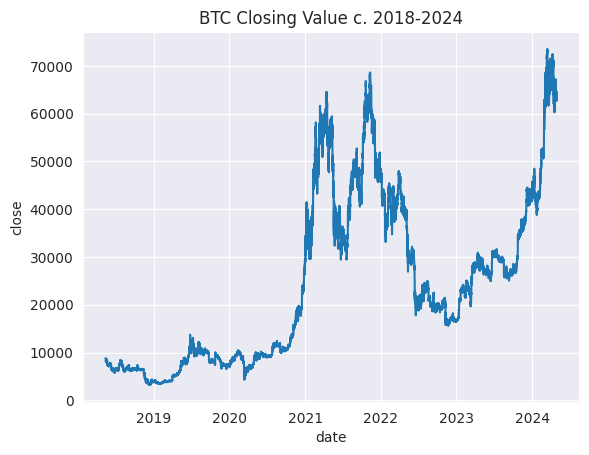

In [9]:
# Let's take a look at BTC before considering CCF with other coins.
ax = sns.lineplot(data=df_bitcoin, x='date', y='close')
ax.set_title('BTC Closing Value c. 2018-2024')
plt.show()

### Let's take a look at the stationarity of the time series.

In [10]:
btc_close = dct_coin_tables['BTC']['close'].to_numpy()
ether_close = dct_coin_tables['ETH']['close'].to_numpy()
btc_close_diff = np.diff(btc_close)
ether_close_diff = np.diff(ether_close)

# Ether starts later than BTC.
eth_start = dct_coin_tables['ETH']['date'].min()
mask_for_btc = dct_coin_tables['BTC']['date'] >= eth_start
btc_close = btc_close[mask_for_btc]

print('ADF Test Results:\nBTC: {} ---- df BTC: {}\nEther: {} ---- df ETHER: {}'.format(adfuller(btc_close), adfuller(btc_close_diff), adfuller(ether_close), adfuller(ether_close_diff)))
# test_corr = ccf(btc_close, ether_close)

ADF Test Results:
BTC: (-0.5592064050819889, 0.8799358932978059, 58, 52126, {'1%': -3.430475457968319, '5%': -2.861595449895273, '10%': -2.5667995141366813}, 708538.0541992125) ---- df BTC: (-29.533756506479985, 0.0, 58, 52125, {'1%': -3.4304754603753054, '5%': -2.86159545095909, '10%': -2.56679951470292}, 708521.2504354062)
Ether: (-1.132333527099498, 0.7020069838427792, 58, 52118, {'1%': -3.430475477226794, '5%': -2.861595458406951, '10%': -2.566799518667196}, 436275.5556912424) ---- df ETHER: (-29.16435050465613, 0.0, 57, 52118, {'1%': -3.430475477226794, '5%': -2.861595458406951, '10%': -2.566799518667196}, 436267.2447307998)


### The results suggest BTC and ETH are weakly non-stationary, so for the purposes of correlation, we'll use backward difference, which is strongly non-stationary.

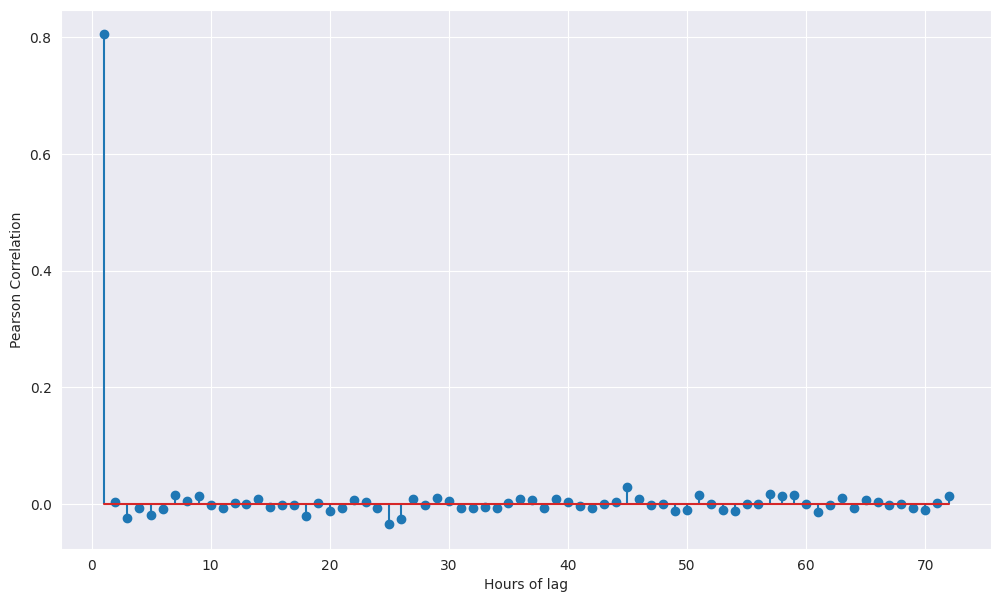

In [19]:
# Need to line up the BTC/ETH datasets first, they don't have precisely the same date records. Ether winds up having a few NULL values, but trivially small in number, so we'll just forward fill.
df_btc_eth = df_bitcoin[['date', 'close']].merge(dct_coin_tables['ETH'][['date', 'close']], how='left', on='date', suffixes=['_btc', '_eth'])
df_btc_eth['close_eth'] = df_btc_eth['close_eth'].ffill()

btc_close_diff = np.diff(df_btc_eth['close_btc'].to_numpy())
eth_close_diff = np.diff(df_btc_eth['close_eth'].to_numpy())

# I want to look at lag intervals of one hour, i.e. each row of the crypto datasets, so luckily there's no need to do anything special. Let's look at a lag of up to 72 hours.
lag_vals = 72
conf_interv = 0.05
lagged_corr, lag_conf_intervals = ccf(btc_close_diff, eth_close_diff, nlags=lag_vals, alpha=conf_interv)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
x = range(1, lag_vals + 1, 1)
plt.stem(x, lagged_corr, label='Lagged Cross-Correlation between BTC and ETH')
ax.set_xlabel('Hours of lag')
ax.set_ylabel('Pearson Correlation')
plt.show()

### Now that we've taken a look at the crypto data, let's load the tweet dataset and proceed with feature extraction. The tweet data includes raw tweets, as well as sentiment data from an up-to-date roBERTa model.

In [5]:
tweet_sent_path = Path(data_folder / 'tweets_and_sent.pickle')

df_tweets = pd.read_pickle(tweet_sent_path)
print("Tweet and sentiment shape: {}".format(df_tweets.shape))

Tweet and sentiment shape: (5261255, 10)


### The sentiment has already been processed, but I also want to directly use tokenized tweets as features in some way.
To accomplish this, I need to do some cleaning that wasn't necessary for sentiment analysis.

In [ ]:
# A pipeline is created to use precisely the same resources as the sentiment extraction. Stop words and punctuation are removed,
# html tags stripped, URLs are stripped, and then the text is lemmatized and concatenated back into a 'sentence' for token 
# extraction.

path_clean_tweet_tokens = Path(data_folder / 'clean_tweet_tokens.pickle')
overwrite = False
if overwrite or not path_clean_tweet_tokens.exists():
    from transformers import pipeline
    sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=0)

    # Any weird words I want to include.
    additional_words = []

    remove_words = set(stopwords.words('english') + list(punctuation) + additional_words)
    cleaned_tweets = []


    def clean_tweet(text):
        # First do pre-split cleaning
        text = text.lower()
        text = BeautifulSoup(text, 'lxml').text

        # Any regex matches you want to drop. Opening HTML strikethroughs were leaking through for example.
        # Explanation of regexes: [remove <xxx> up to 3 letters enclosed, remove URLs,  ]
        regex_list = ['<[^>]+>', r'http\S+']
        for regex in regex_list:
            text = re.sub(regex, '', text)

        # Tokenized cleaning
        text_split = word_tokenize(text)
        stopwords_removed = [word for word in text_split if word not in remove_words]
        lemmatizer = WordNetLemmatizer()
        cleaned_text = [lemmatizer.lemmatize(word) for word in stopwords_removed]

        return " ".join(cleaned_text)

    all_tweets = df_tweets['text'].to_list()

    # This is cpu bound.
    start = time()
    num_cores = mp.cpu_count() - 2
    with mp.Pool(processes=num_cores) as pool:
        cleaned_tweets = list(pool.map(clean_tweet, all_tweets))
    end = time()
    print("Time taken to clean tweets: {}".format(end - start))

    tweet_tokens = sentiment_pipeline.tokenizer(cleaned_tweets, max_length=64, truncation=True, padding=True)
    token_output = [np.resize(np.array(enc.ids), 64) for enc in tweet_tokens.encodings]
    assert (len(token_output) == df_tweets.shape[0])
    mat_tokens = np.array(token_output).astype(int)

    pd.to_pickle(mat_tokens, path_clean_tweet_tokens)

else:
    mat_tokens = pd.read_pickle(path_clean_tweet_tokens)

### Now turning to the crypto data, we drop any falling outside the date-range of the tweets. In practice, there could be reasons to exclude this, and certain models would handle the missing data, but I'm choosing to line it all up here.

In [6]:
assert(df_bitcoin['date'].dtype == df_tweets['date'].dtype)
date_start = df_tweets['date'].min()
date_end = df_tweets['date'].max()

# Note the date mask needs to be kept around for some models and not others. In some cases, e.g. TFT, I believe the
# tweet data can be nan-filled and used with the full crypto dataset. In others, e.g. ARIMA, I believe all multivariate
# features need to be present.
mask_dates = (df_bitcoin['date'] >= date_start) & (df_bitcoin['date'] <= date_end)
mask_dates = mask_dates.to_numpy()
# mask_dates = np.where(mask_dates.to_numpy())[0]
print(np.sum(mask_dates))
# This is a view, be mindful of indices.
df_bitcoin_post_tweets = df_bitcoin[mask_dates]

19129


### Over half the tweets have a neutral sentiment, so collapsing the sentiment scores to a single column isn't feasible. Thus we collect indices for negative/positive/neutral sentiment rows. These will be used to filter downstream and produce hour-by-hour features.  

In [ ]:

positive_cnt = np.sum(df_tweets['label'] == 'positive')
negative_cnt = np.sum(df_tweets['label'] == 'negative')
neutral_cnt = np.sum(df_tweets['label'] == 'neutral')
print('Tweets %:\nPositive: {}\nNegative: {}\nNeutral: {}'.format(positive_cnt/df_tweets.shape[0], negative_cnt/df_tweets.shape[0], neutral_cnt/df_tweets.shape[0]))
dct_sent_label_masks = {}
sent_labels = ['negative', 'neutral', 'positive']
for label in sent_labels:
    idx_temp = np.where(df_tweets['label'] == label)[0]
    dct_sent_label_masks[label] = idx_temp


# In preparation for feature extraction a list of index sets is created. Each one corresponds to the hour immediately following the timestamp in the crypto dataset, allowing the tweet data to be grouped by these hours for feature extraction.
Note that the heavy lifting for this is done in the utils_multiprocess module. Most of this stuff wound up being CPU bound, so I wrote a general wrapper to pass a mapping function, a mapping source, and arbitrary numpy arrays. These numpy arrays are then
written to shared memory, allowing them to be used simultaneously by all the processes without copying. Without this, multiprocessing would have been too slow, due to writing large (~2GB) numpy arrays to each process. By using shared memory, the multiprocess
speedup was more or less linear. This was particularly helpful with the iterative index intersections that would become necessary for each sentiment type.

In [ ]:
from local_analysis.forecasting import utils_multiprocess
reload(utils_multiprocess)

# The mapping function. Note this anticipates the structure used by the multiprocess mapping module I wrote, which will use another wrapper
# to pass the shared memory numpy arrays in a dictionary to the mapping function.
def get_date_mask(date_range, dct_shared_data) -> np.ndarray:

    tweet_dates = dct_shared_data['tweet_dates']['ndarray']
    mask_output = np.where((tweet_dates >= date_range[0]) & (tweet_dates < date_range[1]))[0]

    return mask_output

# To calculate the date-pairs we add something like 59m to each hourly start time. Shared mem numpy arrays need to be memory-contiguous, so 
# datetime objects are a problem - we switch to Posix time instead.
pair_starts = df_bitcoin_post_tweets['date'].astype('int64') / 10 ** 9
pair_starts = pair_starts.astype(int).to_numpy()
pair_ends = pair_starts + 59*60 + 59
date_pairs = list(zip(pair_starts[0:-1], pair_ends[0:-1]))

tweet_dates = df_tweets['date'].astype('int64') / 10 ** 9
tweet_dates = tweet_dates.astype(int).to_numpy()

# Set up the arguments for shared memory multiprocess wrapper.
shared_data = {'tweet_dates': tweet_dates}
input_data = (date_pairs,)
mp_settings = {'num_cores_kept_free': 2}

start = time()
date_pair_masks_multicore = utils_multiprocess.run_shared_mem_multiproc_map(input_data, get_date_mask, shared_data, mp_settings)
end = time()
print('Time taken to run multiprocessing map: {} seconds'.format(end - start))